In [1]:
%%javascript
/** Below because this notebook is pretty large */
var rto = 800;
console.log('NB: Increase require timeout to ' + rto + ' seconds');
window.requirejs.config({waitSeconds: rto});

<IPython.core.display.Javascript object>

# Overview


[Import Packages](#Import-Packages) - Import all packages required

[Data Import](#Data-Import) - Import all data required

[Restrict Movement Types in Demand Data](#Restrict-Movement-Types-in-Demand-Data) - Restrict movement types, examine number of SKUs

[Create SKU-location IDs](#Create-SKU_location-IDs) - Create unique IDs for demand, lead-time and forecast line data 

[Next Steps post EDA](#Next-Steps-post-EDA) - Thoughts on next steps

[Filter SKUs to those in demand and lead-time data](#Filter-SKUs-to-those-in-demand-and-lead-time-data) - As title 

[Calculate safety stock quantities for SKUs](#Calculate-safety-stock-quantities-for-SKUs) - Quite long, calculate all quantities required for safety stock calculation. Create results df, add z score, calculate mean demand, overwrite with monthly mean demand, calculate standard deviation of demand and (overwrite with) std dev of monthly demand. Then calc mean lead-time and std dev of lead-time.  

[Use mean lead-time from info records](#Use-mean-lead-time-from-info-records) - Amendment to calculation. Previously, calculated lead-times manually. Adjusted to use info records. This section does that. But we still use std dev from manual calculations, as info records don't give us std dev of lead-time. 

[Calculate safety stock, with now calculated quantities](#Calculate-safety-stock,-with-now-calculated-quantities) - Finally, use calculated quantities to output safety stock levels, lead-time demand and re-order point 

[Join MARC_EISBE (safety stock levels in SAP) to all VPV, VPF SKUs](#Join-MARC_EISBE,-safety-stock-levels-in-SAP,-to-all-VPV/VPF-SKUs) - Add current safety stock levels from SAP for comparison 

[Thoughts on forecast lines and std_dev](#Thoughts-on-forecast-lines-and-std_dev) - As title

[Calculate expected increase in stock values](#Calculate-expected-increase-in-stock-values) -Using price data, get price per unit of products (V or S price), and calculated expected stock value increases due to safety stocks, by comparing current SS level and proposed

[Output TX Runner CSV](#Output-TX-Runner-CSV) - Output csv, with safety stock levels, in format required to update SS' via TX Runner. 

[Output further diagnostics](#Output-further-diagnostics) - Output more information, to a separate diagnostics file, which can help stakeholders track the calculation better, and give them info on each product 

[Output stock value change file](#Output-stock-value-change-file) 

[OTIF Calculations](#OTIF-Calculations) - Use delivery data to calculate gap between desired service level, and actual OTIF levels per product. Use some rudimentary assumptions to estimate the 'margin at risk' for the products in this analysis. Use this to propose a business value for these safety stock increases. 

[Second stage diagnostics'](#Second-stage-diagnostics) - Some further EDA, with some plots of history, of the SS calculations. Pretty helpful I found for visualising underlying data.  

# Import Packages 

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import importlib
import os.path as path
import matplotlib as mpl
import time
from datetime import datetime
import random
import pickle
import importlib
import time
import scipy.stats as st
import datetime as dt

# Data Import

Data overview:
    
1. Demand  
    a. Angle: Demand Data MSEG  
    b. Filters: planning profile contains vpv, vpf. Plant contains EN.  
2. Forecast lines  
    a. Angle: Forecast Lines Data  
    b. Filters: MRP relevant = yes. consumption indicator = 1. Plant contains EN.   
3. Lead times   
    a. Angle: Lead_times_class_planning_profile
    b. Filters: planning profile contains vpv, vpf   
4. Lead times  
    a. Angle: Info Records for Lead Times  
    b. Filters: Purchasing Organization = EN01  
5. Source list  
    a. Angle: Source List   
    b. Filters: Purchase organization = EN01. Planning profile contains vpv, vpf   
6. Price data - material plant - vpv, vpf, EN plant  
    a. Angle: Price data angle   
    b. Filters: Plant contains EN. Planning profile contain vpv, vpf   
7. OTIF data   
    a. Angle: OTIF Data  
    b. Filters: planning profile contains vpv, vpf. Issuing plant short name contains EN.   
8. PTG data   
    a. Angle: Material Sales for Safety Stock Levels   
    b. Filters: Planning profile contains vpv, vpf. Sales Organization = EN01.   


## Demand data

In [3]:
filepath = r"X:\Data\Angle2csv\NL\DA\Demand data MSEG.csv"
df_demand = pd.read_csv(filepath, sep=';', decimal = '.')
df_demand['(Self) Quantity +/-'] = df_demand['(Self) Quantity +/-'].apply(lambda x: x.replace(',','.'))

## Lead-time Data

In [4]:
filepath = r"X:\Data\Angle2csv\NL\DA\Lead_times_class_planning_profile.csv"
df_lt = pd.read_csv(filepath, sep=';')

## Forecast Lines Data

In [5]:
filepath = r"X:\Data\Angle2csv\NL\DA\Forecast Lines Data.csv"
df_forecast_lines = pd.read_csv(filepath, sep=';')
print (len(df_forecast_lines))
df_forecast_lines['(Self) Material Value'] = df_forecast_lines['(Self) Material Value'].apply(lambda x: x.replace(',','.'))
df_forecast_lines['(Self) Open Quantity Value'] = df_forecast_lines['(Self) Open Quantity Value'].apply(lambda x: x.replace(',','.'))
df_forecast_lines['(Self) Quantity'] = df_forecast_lines['(Self) Quantity'].apply(lambda x: x.replace(',','.'))

14164


# Restrict Movement Types in Demand Data

In [6]:
# Remove text from movement type code
df_demand['(Self) Movement Type - code'] = df_demand['(Self) Movement Type'].str[:3]

In [7]:
# Filter the list on demand movement types (as from Hans)
movement_type_list = ['201','202','261','262','633', '634', '601', '643']
df_demand_movement_type_filtered = df_demand[df_demand['(Self) Movement Type - code'].isin(movement_type_list)]

# Create SKU_location IDs

## Demand data

In [8]:
# Remove surplus text from Plant field
df_demand_movement_type_filtered['Plant Plant'] = df_demand_movement_type_filtered['Plant Plant'].str[:4]
df_demand_movement_type_filtered['Plant Plant'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


EN01    155434
EN04      4520
EN05        14
EN11         2
Name: Plant Plant, dtype: int64

In [9]:
# Convert material to string, sometimes becomes int
df_demand_movement_type_filtered['Material Material'] = df_demand_movement_type_filtered['Material Material'].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Combine plant and material columns to create unique ID
df_demand_movement_type_filtered['Plant-Material'] = df_demand_movement_type_filtered['Plant Plant'] + df_demand_movement_type_filtered['Material Material']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Forecast lines data

In [11]:
# Remove surplus text from plant data for forecast lines
df_forecast_lines['Plant Plant'] = df_forecast_lines['Plant Plant'].str[:4]
df_forecast_lines['Plant Plant'].value_counts()

EN01    14164
Name: Plant Plant, dtype: int64

In [12]:
df_forecast_lines['Material Material'] = df_forecast_lines['Material Material'].astype(str)
# Create ID for forecast lines
df_forecast_lines['Plant-Material'] = df_forecast_lines['Plant Plant'] + df_forecast_lines['Material Material']

In [13]:
df_forecast_lines.head()

,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,...,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material
0,Indep. Req.,VSF 2022-04-01/202204,Open,EN01,10014736,Hose Flexair EF-1 PVC coil=6m 102,6,m,0,6,...,1 (Consume only with customer requirements),NaN,False,1,NaN,1,"20,375",NaN,True,EN0110014736
1,Indep. Req.,VSF 2022-09-01/202209,Open,EN01,10014736,Hose Flexair EF-1 PVC coil=6m 102,6,m,0,6,...,1 (Consume only with customer requirements),NaN,False,1,NaN,1,"20,375",NaN,True,EN0110014736
2,Indep. Req.,VSF 2022-02-01/202202,Open,EN01,10015458,Hose Abratape 06 Food coil=15m 50x4,360,m,0,360,...,1 (Consume only with customer requirements),NaN,False,1,NaN,1,"2302,8397351",NaN,True,EN0110015458
3,Indep. Req.,VSF 2022-06-01/202206,Open,EN01,10015458,Hose Abratape 06 Food coil=15m 50x4,270,m,0,270,...,1 (Consume only with customer requirements),NaN,False,1,NaN,0,0,NaN,True,EN0110015458
4,Indep. Req.,VSF 2022-09-01/202209,Open,EN01,10015458,Hose Abratape 06 Food coil=15m 50x4,240,m,0,240,...,1 (Consume only with customer requirements),NaN,False,1,NaN,0,0,NaN,True,EN0110015458


## Lead-time data

In [14]:
df_lt['Plant Plant'].value_counts()

EN01 (ERIKS BV Alkmaar)      31913
EB01 (ERIKS NV Hoboken)       4614
EF02 (ERIKS sas Lyon)         2363
EB25 (ERIKS NV Antwerpen)     1512
EB07 (ERIKS NV Mollem)        1220
EB05 (ERIKS NV Mol)           1061
EN04 (ERIKS BV Capelle)       1042
EN11 (ERIKS BV Rijnmond)        74
EN05 (ERIKS BV Rotterdam)       23
EF20 (ERIKS Lille)               1
Name: Plant Plant, dtype: int64

In [15]:
df_lt['Material Material'] = df_lt['Material Material'].astype(str)
df_lt['Plant Plant'] = df_lt['Plant Plant'].str[:4]
# Create unique ID for lead times data
df_lt['Plant-Material'] = df_lt['Plant Plant'] + df_lt['Material Material']
df_lt.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,...,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material
0,PD Schedule Line,4200046167/10/1,EF02 (ERIKS sas),EF02,Closed,13101146,Sachet larg.650xht.600 m.p *,4965,Piece,Sachet larg.650xht.600 m.p *,...,21-01-2020,Delivered on time,False,"1040,31645",16-01-2020,10-12-2019,NaN,VPFZ,NORM (Standard item),EF0213101146
1,PD Schedule Line,4200046167/10/2,EF02 (ERIKS sas),EF02,Cancelled,13101146,Sachet larg.650xht.600 m.p *,35,Piece,Sachet larg.650xht.600 m.p *,...,21-01-2020,Not applicable,False,0,NaN,10-12-2019,NaN,VPFZ,NORM (Standard item),EF0213101146
2,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,28-01-2021,Delivered on time,False,300,26-01-2021,18-01-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
3,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,22-03-2021,Delivered on time,False,400,19-03-2021,10-03-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
4,PD Schedule Line,4200056695/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,30-09-2021,Delivered on time,False,300,30-09-2021,24-09-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447


# Next Steps post EDA

We've now:
1. Filtered the data to NL. 
3. Created a Plant-SKU unique identifier for both datasets. 

Next we want to:
1. Filter the SKU set to be only those which are in the lead-time AND demand datasets. 
2. Calculate, for these SKUs:  
    a. Average demand  
    b. Standard deviation in demand  
    c. Average lead-time  
    d. Standard deviation in lead-time   
3. Combine these values into a separate 'results' dataframe.
4. Calculate safety stock levels for all these SKUs. 

# Filter SKUs to those in demand and lead-time data

In [16]:
df_demand_movement_type_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material
69878,MDoc Item,174302475/2019/5,02-01-2019,261 (GI for order),WA (Goods issue),12682354,"Nut 12444 DIN/BS/ISO 304 DN15-1/2""",1,1360,Piece,...,-1,108538,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261,EN0112682354
69883,MDoc Item,174302539/2019/1,02-01-2019,261 (GI for order),WA (Goods issue),11547497,"Hose ERIFLON 2111 AS L=18m DN12-1/2""","0,8","128,804",m,...,-0.8,108539,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0111547497
69884,MDoc Item,174302539/2019/2,02-01-2019,261 (GI for order),WA (Goods issue),13465090,"ASM FERRULE 2111 FIV SS 1/2""",4,596,Piece,...,-4,108539,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,C (Material - Low Significance),261\0,Piece (items),261,EN0113465090
69885,MDoc Item,174302539/2019/3,02-01-2019,261 (GI for order),WA (Goods issue),13465155,"ASM CONN 2111 FIV SS DN12 12,7x1,24",4,368,Piece,...,-4,108539,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,C (Material - Low Significance),261\0,Piece (items),261,EN0113465155
69886,MDoc Item,174302545/2019/1,02-01-2019,261 (GI for order),WA (Goods issue),12673847,ASM hose Wtz RS321S12 DN12 489.72078,"119,68","571,16",m,...,-119.68,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0112673847


In [17]:
# Get unique list of IDs in demand data
SKUs_demand_data = df_demand_movement_type_filtered['Plant-Material'].unique().tolist()
# Get unique list of IDs in lead time data
SKUs_lt_data = df_lt['Plant-Material'].unique().tolist()
# How many IDs in both datasets? 
print (len(set(SKUs_demand_data) & set(SKUs_lt_data)))

2161


In [18]:
# Line to filter demand data on SKUs in LT data
df_demand_movement_type_filtered_lt_SKUs_filtered = df_demand_movement_type_filtered[df_demand_movement_type_filtered['Plant-Material'].isin(df_lt['Plant-Material'])]

In [19]:
# Count how many SKUs remain post LT filtering
df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'].nunique()

2161

In [20]:
#Check how many rows remain in demand data
print (len(df_demand_movement_type_filtered_lt_SKUs_filtered))

127425


In [21]:
# Filter LT SKUs based on SKUs in demand data
df_lt_demand_SKUs_filtered = df_lt[df_lt['Plant-Material'].isin(df_demand_movement_type_filtered['Plant-Material'])]

In [22]:
# Count how many SKUs remain post demand data filtering
df_lt_demand_SKUs_filtered['Plant-Material'].nunique()

2161

In [23]:
# Check length of new LT dataframe
print (len(df_lt_demand_SKUs_filtered))

32762


# Calculate safety stock quantities for SKUs:

## Create results dataframe, to store quantities, and eventual safety stock

In [24]:
# Create set object for SKUs in both datasets
set_of_SKUs = set(SKUs_demand_data) & set(SKUs_lt_data)

In [25]:
# Create empty results dataframe, to store safety stock calculations
safety_stocks_df = pd.DataFrame(index = set_of_SKUs)
safety_stocks_df['ABC_class'] = np.nan
safety_stocks_df['DSL'] = np.nan
safety_stocks_df['mean_demand'] = np.nan
safety_stocks_df['std_dev_demand'] = np.nan
safety_stocks_df['mean_lead_time'] = np.nan
safety_stocks_df['std_dev_lead_time'] = np.nan
safety_stocks_df['safety_stock'] = np.nan

## Add in Z-score for SKUs, based on ABC classes

### Add ABC class data to safety stocks df

In [26]:
# Get one row per ID, assuming ABC class stays constant through all lead time 
# Ideally, would double check this, to make sure we're using the latest ABC class, and to do some EDA on how often class changes. 
df_lt_one_row_per_SKU = df_lt.groupby('Plant-Material').head(1).reset_index(drop=True)

df_lt_one_row_per_SKU['Plant-Material'] = df_lt_one_row_per_SKU['Plant-Material'].astype(str)

# Join ABC classes to safety stocks results df
safety_stocks_df = safety_stocks_df.merge(
         df_lt_one_row_per_SKU[['Plant-Material', 'Material Plant ABC Indicator']], 
         left_index = True,
         right_on = 'Plant-Material').set_index('Plant-Material')


In [27]:
# Restrict ABC class field to first letter
safety_stocks_df['Material Plant ABC Indicator'] = safety_stocks_df['Material Plant ABC Indicator'].str[:1]

In [28]:
safety_stocks_df['Material Plant ABC Indicator'].value_counts()

B    788
C    724
A    465
D    171
N      8
F      4
Name: Material Plant ABC Indicator, dtype: int64

In [29]:
safety_stocks_df['ABC_class'] = safety_stocks_df['Material Plant ABC Indicator']
# Remove unrequired column
del safety_stocks_df['Material Plant ABC Indicator']
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock
Plant-Material,,,,,,,
EN0112481448,C,NaN,NaN,NaN,NaN,NaN,NaN
EN0112692261,B,NaN,NaN,NaN,NaN,NaN,NaN
EN0112474732,C,NaN,NaN,NaN,NaN,NaN,NaN
EN0114236652,C,NaN,NaN,NaN,NaN,NaN,NaN
EN0112330703,A,NaN,NaN,NaN,NaN,NaN,NaN


We have more than just A, B and C classes, so for now, we're going to set the desired service levels (DSL) to:
1. A - 98%
2. B - 95% 
3. C and other - 90%

### Fill in DSL from ABC class

In [30]:
# Hard-coded service levels for ABC classes. 
# Business may want these to change from time to time 
Class_A_DSL = 98
Class_B_DSL = 95
Class_C_DSL = 90
Class_rest_DSL = 80

In [31]:
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'A', 'DSL'] = Class_A_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'B', 'DSL'] = Class_B_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'C', 'DSL'] = Class_C_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'D', 'DSL'] = Class_rest_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'N', 'DSL'] = Class_rest_DSL


### Calculate Z-score via DSL

In [32]:
# Calc value on normal distribution, when we get 98% of probability (cumulative distribution function/left to right)
safety_stocks_df['Z_score'] = st.norm.ppf(safety_stocks_df['DSL']/100.0) 

In [33]:
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score
Plant-Material,,,,,,,,
EN0112481448,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552
EN0112692261,B,95.0,NaN,NaN,NaN,NaN,NaN,1.644854
EN0112474732,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552
EN0114236652,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552
EN0112330703,A,98.0,NaN,NaN,NaN,NaN,NaN,2.053749


## Calculate mean demand

Okay, so we want to add up the total demand for each SKU. We have two columns which we could use, '(Self) Quantity' and '(Self) Quantity +/-'. It seems that the movement types (262 and 202) give positive values. 
We'll need to double check this with the team. For now, I'm going to push forward with '(Self) Quantity +/-'. We want to flip the positive and negative values, as demand should be positive, but looks to be negative in this dataset. Whereas, what I assume are returns, are denoted positively (and are far fewer in frequency), and that should be negative demand. 


In [34]:
# Flip sign of demand (orders leaving factory = negative, we want it to be positive)
df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/- flipped'] = -1.0 * df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/-'].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Calculate monthly mean demand

Business requested monthly mean demand, so this has been calculated after daily mean demand, similarly to above. 

In [35]:
# Convert date column to datetime
df_demand_movement_type_filtered_lt_SKUs_filtered['MDoc Header Posting Date'] = pd.to_datetime(
    df_demand_movement_type_filtered_lt_SKUs_filtered['MDoc Header Posting Date'], 
    format="%d-%m-%Y", 
    errors='coerce')

# Convert date cols used to datetime
df_forecast_lines['(Self) Order Due Date'] = pd.to_datetime(
    df_forecast_lines['(Self) Order Due Date'], 
    format="%d-%m-%Y", 
    errors='coerce')

df_forecast_lines['(Self) Quantity'] = df_forecast_lines['(Self) Quantity'].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [36]:
# Rename some columns to join material docs and forecast lines below
df_forecast_lines = df_forecast_lines.rename(columns = {
    '(Self) Order Due Date': 'MDoc Header Posting Date',
    '(Self) Quantity': '(Self) Quantity +/- flipped'   
})

In [37]:
df_forecast_lines['(Self) Quantity +/- flipped'].describe()

count     14164.000000
mean       3777.559870
std        9512.034283
min           1.000000
25%         220.000000
50%         761.000000
75%        2500.000000
max      161000.000000
Name: (Self) Quantity +/- flipped, dtype: float64

In [38]:
# Join forecast lines to material docs, for quicker calculations of monthly demand
# Done slightly different to daily demand 
material_docs_plus_forecast_lines = df_demand_movement_type_filtered_lt_SKUs_filtered.append(df_forecast_lines)

In [39]:
# Get total demand per month, per ID
material_docs_plus_forecast_lines_grouped = material_docs_plus_forecast_lines.groupby([pd.Grouper(key='MDoc Header Posting Date', freq='MS'), 'Plant-Material'])['(Self) Quantity +/- flipped'].sum()

In [40]:
material_docs_plus_forecast_lines_grouped.head()

MDoc Header Posting Date  Plant-Material
2019-01-01                EN0110014281       7.00
                          EN0110014442       1.00
                          EN0110014530      60.40
                          EN0110014531      34.40
                          EN0110014532      14.24
Name: (Self) Quantity +/- flipped, dtype: float64

Note: Double check the zero demand months. Are they included in the above result? 

In [41]:
# Cast result to dataframe
material_docs_plus_forecast_lines_grouped_df = material_docs_plus_forecast_lines_grouped.to_frame()

In [42]:
# Can get mean monthly demand by grouping by ID, and taking mean
mean_monthly_demand = material_docs_plus_forecast_lines_grouped_df.groupby('Plant-Material').mean()

In [43]:
mean_monthly_demand.head()

,(Self) Quantity +/- flipped
Plant-Material,
EN0110014281,30.125000
EN0110014442,1.700000
EN0110014530,90.238750
EN0110014531,34.022361
EN0110014532,45.195556


## Append mean monthly demand to results df

In [44]:
# Here, we overwrite the previous mean_demand calculation (on a daily level), with the newly requested monthly calculation
safety_stocks_df = safety_stocks_df.merge(
         mean_monthly_demand, 
         left_index = True,
         right_index = True)

del safety_stocks_df['mean_demand']

safety_stocks_df.rename(columns={"(Self) Quantity +/- flipped": "mean_demand"}, inplace = True)
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0112481448,C,90.0,NaN,NaN,NaN,NaN,1.281552,52.277778
EN0112692261,B,95.0,NaN,NaN,NaN,NaN,1.644854,34.225806
EN0112474732,C,90.0,NaN,NaN,NaN,NaN,1.281552,3.400000
EN0114236652,C,90.0,NaN,NaN,NaN,NaN,1.281552,2.904667
EN0112330703,A,98.0,NaN,NaN,NaN,NaN,2.053749,24854.448980


## Calculate standard deviation of demand 

### Calculate std dev of monthly demand

Again, we overwrite the daily std dev demand calc, with the monthly equivalent

In [45]:
# Note, we use an earlier dataframe, which already has the monthly grouped data, and calculate the std_dev per ID
std_dev_monthly_demand = material_docs_plus_forecast_lines_grouped_df.groupby('Plant-Material').std()

In [46]:
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0112481448,C,90.0,NaN,NaN,NaN,NaN,1.281552,52.277778
EN0112692261,B,95.0,NaN,NaN,NaN,NaN,1.644854,34.225806
EN0112474732,C,90.0,NaN,NaN,NaN,NaN,1.281552,3.400000
EN0114236652,C,90.0,NaN,NaN,NaN,NaN,1.281552,2.904667
EN0112330703,A,98.0,NaN,NaN,NaN,NaN,2.053749,24854.448980


In [47]:
del safety_stocks_df['std_dev_demand']

In [48]:
# Join monthly std dev to results dataframe, having deleted previous result on daily level
safety_stocks_df = safety_stocks_df.merge(
         std_dev_monthly_demand, 
         left_index = True,
         right_index = True)


safety_stocks_df.rename(columns={"(Self) Quantity +/- flipped": "std_dev_demand"}, inplace = True)
safety_stocks_df.head()

,ABC_class,DSL,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand
Plant-Material,,,,,,,,
EN0112481448,C,90.0,NaN,NaN,NaN,1.281552,52.277778,37.244511
EN0112692261,B,95.0,NaN,NaN,NaN,1.644854,34.225806,21.715908
EN0112474732,C,90.0,NaN,NaN,NaN,1.281552,3.400000,3.781534
EN0114236652,C,90.0,NaN,NaN,NaN,1.281552,2.904667,2.680637
EN0112330703,A,98.0,NaN,NaN,NaN,2.053749,24854.448980,16664.677886


## Calculate Lead-time in days (legacy code, but needed for standard deviation calculation)

Lead-time = (Self) Date of Goods Receipt - LastPrintMessageZNEU Processing date

In [49]:
# Cast date columns used to datetime
df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'] = pd.to_datetime(df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'], format="%d-%m-%Y", errors='coerce')
df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'] = pd.to_datetime(df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'], format="%d-%m-%Y", errors='coerce')



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
# Subtract two date columns to get lead time
df_lt_demand_SKUs_filtered['Lead-time in days'] = (df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'] - df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date']).dt.days

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Okay great, so we've got the lead-time in days, for each purchase document, via (Date of Goods Receipt - Processing Date). Now, let's calculate the std dev.

## Calculate standard devation of lead-time

In [51]:

# Group by ID, calc lead time, flatten index, cast ID to index
std_dev_lead_times_df = df_lt_demand_SKUs_filtered.groupby('Plant-Material').agg({'Lead-time in days':np.std}).reset_index().set_index('Plant-Material')
# Rename col for readability
std_dev_lead_times_df = std_dev_lead_times_df.rename(columns = {'Lead-time in days':'std_dev_lead_time'})
std_dev_lead_times_df.head()

,std_dev_lead_time
Plant-Material,
EN0110014281,1.709701
EN0110014442,4.231402
EN0110014530,20.812771
EN0110014531,12.259107
EN0110014532,28.702233


In [52]:
del safety_stocks_df['std_dev_lead_time']

# Join std_dev lead time to results df
safety_stocks_df = safety_stocks_df.merge(
         std_dev_lead_times_df, 
         left_index = True,
         right_index = True)
safety_stocks_df.head()

,ABC_class,DSL,mean_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand,std_dev_lead_time
Plant-Material,,,,,,,,
EN0112481448,C,90.0,NaN,NaN,1.281552,52.277778,37.244511,NaN
EN0112692261,B,95.0,NaN,NaN,1.644854,34.225806,21.715908,25.836734
EN0112474732,C,90.0,NaN,NaN,1.281552,3.400000,3.781534,5.033223
EN0114236652,C,90.0,NaN,NaN,1.281552,2.904667,2.680637,20.506097
EN0112330703,A,98.0,NaN,NaN,2.053749,24854.448980,16664.677886,36.618709


# Use mean lead time from info records:

In [53]:
filepath = r"X:\Data\Angle2csv\NL\DA\Info Records for Lead Times.csv"
df_info_records = pd.read_csv(filepath, sep=';')
df_info_records.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,8,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Active,(Self) Validity Status,Vendor Vendor,Vendor Description,Material Material,Material Description,...,(Self) Purchasing Group,(Self) Planned Deliv. Time,(Self) Created on,(Self) Net Price,(Self) Currency,(Self) Price Unit,(Self) Order Price Unit,(Self) Date of Document,(Self) Minimum Order Qty,(Self) Standard PO Quantity
0,Info Record,5300000030/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016040,Band-it Scru-Seal set SS 201 M210,...,ND7 (J. van Wijngaarden),32,22-12-1998,"98,86",GBP,1,CS,10-12-2021,1,1
1,Info Record,5300000031/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016041,Band-it Scru-Seal 10pc SS 201 M211,...,ND7 (J. van Wijngaarden),21,22-12-1998,"28,3",GBP,1,CS,05-08-2021,20,20
2,Info Record,5300000032/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016060,BAND-IT SCRU LOKT 25ST RVS 201 C724 1/2,...,ND7 (J. van Wijngaarden),27,22-12-1998,"17,22",GBP,1,CS,01-04-2021,1,1
3,Info Record,5300000033/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016061,BAND-IT SCRU LOKT 25ST RVS 201 C726 3/4,...,ND7 (J. van Wijngaarden),21,22-12-1998,"19,25",GBP,1,CS,21-07-2021,1,1
4,Info Record,5300000034/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016062,"Band-it clamp 25pc SS 201 G441 1""",...,ND7 (J. van Wijngaarden),21,22-12-1998,"44,16",GBP,1,CS,19-07-2021,1,1


In [54]:
filepath = r"X:\Data\Angle2csv\NL\DA\Source List.csv"
df_source_list = pd.read_csv(filepath, sep=';')


In [55]:
df_source_list['(Self) Fixed vendor'].value_counts()

True     2275
False     231
Name: (Self) Fixed vendor, dtype: int64

In [56]:
filepath = r"X:\Data\Angle2csv\NL\DA\bu_mapping.csv"
df_bu_mapping = pd.read_csv(filepath)
df_bu_mapping.head()

,LocalProductGroupCode,MaterialGroupCode,BusinessUnit
0,BE-01,BE-02270010,Flow
1,BE-01,BE-02270020,Flow
2,BE-01,BE-02270030,Flow
3,BE-01,BE-02270040,Flow
4,BE-01,BE-02270100,Flow


## Filter source list to just True

In [57]:
df_source_list = df_source_list[df_source_list['(Self) Fixed vendor'] == True]


In [58]:
print (len(df_source_list))
df_source_list['Material Material'].nunique()

2275


2275

## Add Material-Vendor columns to info records and source list dfs

In [59]:
# Create material-vendor ID
df_info_records['Material-Vendor'] = df_info_records['Material Material'].astype(str) + '-' + df_info_records['Vendor Vendor'].astype(str)

In [60]:
# Create material-vendor ID

df_source_list['Material-Vendor'] = df_source_list['Material Material'].astype(str) + '-' + df_source_list['Vendor Vendor'].astype(str)

## Join PDTs from inforecords to source list

In [61]:
df_source_list = pd.merge(df_source_list, 
         df_info_records[['Material-Vendor', '(Self) Planned Deliv. Time']], 
         on='Material-Vendor', 
         how='left')


In [62]:
print (len(df_source_list))

2280


## Create Plant-SKU ID, to join lead-times to safety stocks df

In [63]:
df_source_list['Plant Plant'] = df_source_list['Plant Plant'].str[:4]
df_source_list['Plant-Material'] = df_source_list['Plant Plant'].astype(str) + df_source_list['Material Material'].astype(str)


## Join lead times to safety stocks df

In [64]:
# Join Info Records lead time to results df
safety_stocks_df = safety_stocks_df.merge(
         df_source_list[['Plant-Material', '(Self) Planned Deliv. Time']], 
         left_index = True,
         right_on = 'Plant-Material').set_index('Plant-Material')
safety_stocks_df.head()

# Get rid of previous mean_lead_time column
safety_stocks_df['mean_lead_time'] = safety_stocks_df['(Self) Planned Deliv. Time']
del safety_stocks_df['(Self) Planned Deliv. Time']
safety_stocks_df.head()

,ABC_class,DSL,mean_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand,std_dev_lead_time
Plant-Material,,,,,,,,
EN0112692261,B,95.0,28.0,NaN,1.644854,34.225806,21.715908,25.836734
EN0112474732,C,90.0,14.0,NaN,1.281552,3.400000,3.781534,5.033223
EN0114236652,C,90.0,112.0,NaN,1.281552,2.904667,2.680637,20.506097
EN0112330703,A,98.0,154.0,NaN,2.053749,24854.448980,16664.677886,36.618709
EN0112612956,B,95.0,98.0,NaN,1.644854,6.333333,4.418576,27.910897


# Calculate safety stock, with now calculated quantities

In [65]:
safety_stocks_df.head()

,ABC_class,DSL,mean_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand,std_dev_lead_time
Plant-Material,,,,,,,,
EN0112692261,B,95.0,28.0,NaN,1.644854,34.225806,21.715908,25.836734
EN0112474732,C,90.0,14.0,NaN,1.281552,3.400000,3.781534,5.033223
EN0114236652,C,90.0,112.0,NaN,1.281552,2.904667,2.680637,20.506097
EN0112330703,A,98.0,154.0,NaN,2.053749,24854.448980,16664.677886,36.618709
EN0112612956,B,95.0,98.0,NaN,1.644854,6.333333,4.418576,27.910897


## Scale lead time to months

In [66]:
# Divide by 30 to get values in months
safety_stocks_df['mean_lead_time'] = safety_stocks_df['mean_lead_time'] / 30
safety_stocks_df['std_dev_lead_time'] = safety_stocks_df['std_dev_lead_time'] / 30


## Calculate safety stock levels, lead-time demand and re-order point 

In [67]:

# Lead time demand calculation
safety_stocks_df['lead_time_demand'] = safety_stocks_df['mean_lead_time'] * safety_stocks_df['mean_demand']     
    
# Safety stock calculation
safety_stocks_df['safety_stock'] = safety_stocks_df['Z_score'] * np.sqrt(
    safety_stocks_df['mean_lead_time'] * (safety_stocks_df['std_dev_demand']**2) +
    safety_stocks_df['mean_demand'] * (safety_stocks_df['std_dev_lead_time']**2))

# Reorder point calculation
safety_stocks_df['reorder_point'] = safety_stocks_df['safety_stock'] + safety_stocks_df['lead_time_demand']

safety_stocks_df.head()

,ABC_class,DSL,mean_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand,std_dev_lead_time,lead_time_demand,reorder_point
Plant-Material,,,,,,,,,,
EN0112692261,B,95.0,0.933333,35.489503,1.644854,34.225806,21.715908,0.861224,31.944086,67.433589
EN0112474732,C,90.0,0.466667,3.334261,1.281552,3.400000,3.781534,0.167774,1.586667,4.920927
EN0114236652,C,90.0,3.733333,6.803599,1.281552,2.904667,2.680637,0.683537,10.844089,17.647688
EN0112330703,A,98.0,5.133333,77544.257743,2.053749,24854.448980,16664.677886,1.220624,127586.171429,205130.429171
EN0112612956,B,95.0,3.266667,13.688874,1.644854,6.333333,4.418576,0.930363,20.688889,34.377763


# Join MARC_EISBE, safety stock levels in SAP, to all VPV/VPF SKUs

In [68]:
safety_stocks_df.describe()

,DSL,mean_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand,std_dev_lead_time,lead_time_demand,reorder_point
count,2016.000000,2021.000000,1.784000e+03,2016.000000,2.021000e+03,1959.000000,1808.000000,2.021000e+03,1.784000e+03
mean,92.687500,2.435906,6.752501e+03,1.540016,2.825011e+03,1517.212581,0.683820,1.368409e+04,2.196990e+04
std,4.841566,2.391237,6.698663e+04,0.349057,2.808362e+04,14378.185936,0.638647,1.355555e+05,2.099276e+05
min,80.000000,0.100000,0.000000e+00,0.841621,4.380000e-01,0.000000,0.000000,2.044000e-01,5.354803e-01
25%,90.000000,0.833333,9.861290e+00,1.281552,9.142857e+00,5.345850,0.241139,8.549333e+00,2.027574e+01
50%,95.000000,1.400000,5.085643e+01,1.644854,3.916667e+01,25.187440,0.471893,4.881333e+01,1.172491e+02
75%,95.000000,3.733333,7.493554e+02,1.644854,5.400000e+02,258.018766,0.951796,1.427250e+03,2.720539e+03
max,98.000000,12.366667,2.502899e+06,2.053749,1.159903e+06,564146.978039,5.326871,5.412882e+06,7.915780e+06


In [69]:
filepath = r"X:\Data\Angle2csv\NL\DA\Safety Stock Levels Data.csv"
df_ptg = pd.read_csv(filepath, sep=';')
print (len(df_ptg))
print (df_ptg.columns)
df_ptg.head()

3329
Index(['(Self) Object Type EA', 'Material Material', 'Material Description',
       'Sales Org. Sales Org.', '(Self) Distribution Channel',
       '(Self) Item category group', '(Self) DF distr. chain lvl',
       '(Self) Minimum order qty', 'Material Base Unit of Measure',
       '(Self) Delivery unit', '(Self) Sales unit', '(Self) Material group 1',
       '(Self) Material group 2', '(Self) DChain-spec. status',
       'Material Material Group', 'Material Material Type',
       'Material X-plant matl status', 'Material Demand Last Year',
       'Material Demand Last Quarter',
       'Material Plant EA_PROPERTY_PlanProfiel',
       'Material Plant Material Plant', 'Material Plant Safety Stock'],
      dtype='object')


,(Self) Object Type EA,Material Material,Material Description,Sales Org. Sales Org.,(Self) Distribution Channel,(Self) Item category group,(Self) DF distr. chain lvl,(Self) Minimum order qty,Material Base Unit of Measure,(Self) Delivery unit,...,(Self) Material group 2,(Self) DChain-spec. status,Material Material Group,Material Material Type,Material X-plant matl status,Material Demand Last Year,Material Demand Last Quarter,Material Plant EA_PROPERTY_PlanProfiel,Material Plant Material Plant,Material Plant Safety Stock
0,Material Sales,10014281,Hose cutter,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,1,Piece,1,...,20 (Customer-specific published),Z1 (Standard),06525010 (Other accessories),HALB (Semifinished product),NaN,257,69,VPVZ,10014281/EN01,0
1,Material Sales,10014442,"Spuitpistool Starlet 3/8"" m lans 900",EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,1,Piece,1,...,10 (General published),Z1 (Standard),06500010 (Spray guns),HALB (Semifinished product),NaN,7,1,VPVZ,10014442/EN01,0
2,Material Sales,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,"0,01",m,"0,01",...,90 (Do not publish),Z1 (Standard),06225010 (Hoses type 160M/161M),HALB (Semifinished product),NaN,"348,085","73,32",VPVZ,10014530/EN01,60
3,Material Sales,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,"0,01",m,"0,01",...,90 (Do not publish),Z1 (Standard),06225010 (Hoses type 160M/161M),HALB (Semifinished product),NaN,"374,71","174,91",VPVZ,10014531/EN01,15
4,Material Sales,10014532,Hose ERI-MET 161 MCoil=150m DN25 - 1'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,"0,01",m,"0,01",...,90 (Do not publish),Z1 (Standard),06225010 (Hoses type 160M/161M),HALB (Semifinished product),NaN,"520,05","28,24",VPVZ,10014532/EN01,100


In [70]:

# Trim plant and item category fields, and change data types
df_ptg['Plant'] = df_ptg['Material Plant Material Plant'].str[-4:]
df_ptg['(Self) Item category group - code'] = df_ptg['(Self) Item category group'].str[:4]
df_ptg['Material Material'] = df_ptg['Material Material'].astype(str)
df_ptg['Plant-Material'] = df_ptg['Plant'] + df_ptg['Material Material']

df_ptg.Plant.value_counts()


EN01    3255
EN11      43
EN04      30
EN05       1
Name: Plant, dtype: int64

In [71]:
# Join safety stock data from SAP to results df
safety_stocks_df_with_SAP_ss = pd.merge(safety_stocks_df, 
         df_ptg[['Plant-Material', 'Material Plant Safety Stock']],
         left_index = True,
         right_on='Plant-Material').set_index('Plant-Material')

In [72]:
safety_stocks_df_with_SAP_ss.head(50)

,ABC_class,DSL,mean_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand,std_dev_lead_time,lead_time_demand,reorder_point,Material Plant Safety Stock
Plant-Material,,,,,,,,,,,
EN0112692261,B,95.0,0.933333,35.489503,1.644854,34.225806,21.715908,0.861224,31.944086,67.433589,37
EN0112474732,C,90.0,0.466667,3.334261,1.281552,3.400000,3.781534,0.167774,1.586667,4.920927,0
EN0114236652,C,90.0,3.733333,6.803599,1.281552,2.904667,2.680637,0.683537,10.844089,17.647688,3
EN0112330703,A,98.0,5.133333,77544.257743,2.053749,24854.448980,16664.677886,1.220624,127586.171429,205130.429171,40000
EN0112612956,B,95.0,3.266667,13.688874,1.644854,6.333333,4.418576,0.930363,20.688889,34.377763,6
EN0110014877,C,90.0,0.933333,110.491902,1.281552,82.001250,89.236627,0.117063,76.534500,187.026402,0
EN0112474116,B,95.0,1.966667,148.946983,1.644854,54.904762,64.475503,0.665207,107.979365,256.926348,100
EN0111619767,B,95.0,0.466667,15.508078,1.644854,13.500000,12.121606,1.226946,6.300000,21.808078,0
EN0114084930,C,90.0,1.900000,20.174180,1.281552,17.000000,11.414277,0.125462,32.300000,52.474180,10


In [73]:
cols = list(safety_stocks_df_with_SAP_ss.columns.values)
print (cols)

['ABC_class', 'DSL', 'mean_lead_time', 'safety_stock', 'Z_score', 'mean_demand', 'std_dev_demand', 'std_dev_lead_time', 'lead_time_demand', 'reorder_point', 'Material Plant Safety Stock']


In [74]:
# Reorder columns
safety_stocks_df_with_SAP_ss_trimmed = safety_stocks_df_with_SAP_ss[['ABC_class',
                             'DSL',
                             'Z_score',
                             'mean_demand',
                             'std_dev_demand',
                             'mean_lead_time',
                             'std_dev_lead_time',                       
                             'safety_stock',
                              'lead_time_demand',
                              'reorder_point',                                       
                             'Material Plant Safety Stock']]
safety_stocks_df_with_SAP_ss_trimmed.head()

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,lead_time_demand,reorder_point,Material Plant Safety Stock
Plant-Material,,,,,,,,,,,
EN0112692261,B,95.0,1.644854,34.225806,21.715908,0.933333,0.861224,35.489503,31.944086,67.433589,37
EN0112474732,C,90.0,1.281552,3.400000,3.781534,0.466667,0.167774,3.334261,1.586667,4.920927,0
EN0114236652,C,90.0,1.281552,2.904667,2.680637,3.733333,0.683537,6.803599,10.844089,17.647688,3
EN0112330703,A,98.0,2.053749,24854.448980,16664.677886,5.133333,1.220624,77544.257743,127586.171429,205130.429171,40000
EN0112612956,B,95.0,1.644854,6.333333,4.418576,3.266667,0.930363,13.688874,20.688889,34.377763,6


In [75]:
pd.options.display.float_format = '{:.2f}'.format
safety_stocks_df_with_SAP_ss_trimmed.head(5)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,lead_time_demand,reorder_point,Material Plant Safety Stock
Plant-Material,,,,,,,,,,,
EN0112692261,B,95.00,1.64,34.23,21.72,0.93,0.86,35.49,31.94,67.43,37
EN0112474732,C,90.00,1.28,3.40,3.78,0.47,0.17,3.33,1.59,4.92,0
EN0114236652,C,90.00,1.28,2.90,2.68,3.73,0.68,6.80,10.84,17.65,3
EN0112330703,A,98.00,2.05,24854.45,16664.68,5.13,1.22,77544.26,127586.17,205130.43,40000
EN0112612956,B,95.00,1.64,6.33,4.42,3.27,0.93,13.69,20.69,34.38,6


In [76]:
safety_stocks_df_with_SAP_ss_trimmed.describe()

,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,lead_time_demand,reorder_point,Material Plant Safety Stock
count,2013.00,2013.00,2018.00,1956.00,2018.00,1805.00,1781.00,2018.00,1781.00,2018.00
mean,92.70,1.54,2829.19,1519.53,2.44,0.68,6763.86,13704.42,22006.87,5402.17
std,4.84,0.35,28104.29,14389.09,2.39,0.64,67042.49,135655.26,210102.45,48320.40
min,80.00,0.84,0.44,0.00,0.10,0.00,0.00,0.20,0.54,0.00
25%,90.00,1.28,9.15,5.35,0.83,0.24,9.87,8.55,20.28,2.00
50%,95.00,1.64,39.66,25.34,1.40,0.47,51.29,49.15,118.11,30.00
75%,95.00,1.64,540.16,259.34,3.73,0.95,749.78,1427.80,2723.61,450.00
max,98.00,2.05,1159903.22,564146.98,12.37,5.33,2502898.72,5412881.70,7915780.42,1600000.00


# Thoughts on forecast lines and std_dev


All the joins look to be working as desired, but a more conceptual problem has come up. 
Should we be including forecast lines in the mean and standard deviation calculations for demand? 
For standard deviation, it's perhaps more obvious. Past order behaviour is likely to vary much more than future order behaviour (double check this with Hans). So past standard deviation is likely to be higher than future. 

But what about mean demand? Well, if we include it, then we assume that customers order in approximately the same volume in their forecast lines, as they actually have in the past. If there's a difference, then we probably shouldn't include forecast lines. We want the mean demand behaviour ACTUALLY OBSERVED in the past, rather than the mean demand behaviour, weighted by what customers say they're going to order in the future. Double check this in meeting on 17/08/21.

# Calculate expected increase in stock values

## Import price data

In [77]:
filepath = r"X:\Data\Angle2csv\NL\DA\Price data.csv"
df_prices = pd.read_csv(filepath, sep=';')
# Replace commas for full stops
df_prices['(Self) Price Control'] = df_prices['(Self) Price Control'].apply(lambda x: x.replace(',','.'))
df_prices['(Self) Total Value'] = df_prices['(Self) Total Value'].apply(lambda x: x.replace(',','.'))
df_prices['(Self) Moving price'] = df_prices['(Self) Moving price'].apply(lambda x: x.replace(',','.'))
df_prices['(Self) Standard price'] = df_prices['(Self) Standard price'].apply(lambda x: x.replace(',','.'))

df_prices.head()

,(Self) Object Type EA,Material Material,Material Description,Plant Plant,(Self) DF at plant level,(Self) Plant-sp.matl status,Material X-plant matl status,(Self) MRP Type,(Self) MRP Controller,(Self) Purchasing Group,...,Material Base Unit of Measure,Purchase Org. Purchase Org.,Stand. Info Rec. Net Price,(Self) Moving price,(Self) EA_PROPERTY_PlanProfiel,Material Material Group,(Self) Price Control,(Self) Price Unit,(Self) Total Value,(Self) Standard price
0,Material Plant,10014281,Hose cutter,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND5 (J. Priester),...,Piece,EN01 (ERIKS BV),"1,69",1.79,VPVZ,06525010 (Other accessories),V (Moving average price/periodic unit price),1,185.64,0
1,Material Plant,10014442,"Spuitpistool Starlet 3/8"" m lans 900",EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,Piece,EN01 (ERIKS BV),"72,74",73.82,VPVZ,06500010 (Spray guns),V (Moving average price/periodic unit price),1,147.64,0
2,Material Plant,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,m,EN01 (ERIKS BV),"13,39",14.19,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,1276.59,0
3,Material Plant,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,m,EN01 (ERIKS BV),"14,43",15.8,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,1591.8,15.19
4,Material Plant,10014532,Hose ERI-MET 161 MCoil=150m DN25 - 1'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,m,EN01 (ERIKS BV),"15,79",17.29,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,15144.25,0


## Check lengths and unique SKUs

In [78]:
# Trim plant field, change data type and create ID for prices dataset
df_prices['Plant Plant'] = df_prices['Plant Plant'].str[:4]
df_prices['Material Material'] = df_prices['Material Material'].astype(str)
df_prices['Plant-Material'] = df_prices['Plant Plant'] + df_prices['Material Material']


In [79]:
df_prices.head()

,(Self) Object Type EA,Material Material,Material Description,Plant Plant,(Self) DF at plant level,(Self) Plant-sp.matl status,Material X-plant matl status,(Self) MRP Type,(Self) MRP Controller,(Self) Purchasing Group,...,Purchase Org. Purchase Org.,Stand. Info Rec. Net Price,(Self) Moving price,(Self) EA_PROPERTY_PlanProfiel,Material Material Group,(Self) Price Control,(Self) Price Unit,(Self) Total Value,(Self) Standard price,Plant-Material
0,Material Plant,10014281,Hose cutter,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND5 (J. Priester),...,EN01 (ERIKS BV),"1,69",1.79,VPVZ,06525010 (Other accessories),V (Moving average price/periodic unit price),1,185.64,0,EN0110014281
1,Material Plant,10014442,"Spuitpistool Starlet 3/8"" m lans 900",EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,EN01 (ERIKS BV),"72,74",73.82,VPVZ,06500010 (Spray guns),V (Moving average price/periodic unit price),1,147.64,0,EN0110014442
2,Material Plant,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,EN01 (ERIKS BV),"13,39",14.19,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,1276.59,0,EN0110014530
3,Material Plant,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,EN01 (ERIKS BV),"14,43",15.8,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,1591.8,15.19,EN0110014531
4,Material Plant,10014532,Hose ERI-MET 161 MCoil=150m DN25 - 1'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,EN01 (ERIKS BV),"15,79",17.29,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,15144.25,0,EN0110014532


In [80]:
# Count number of rows in data
print (len(df_prices))

# Count number of unique plant SKU combos
df_prices['Plant-Material'].nunique()



3421


3421

## Check for multiple Price Control entries for any SKU

There's some complicated logic that we should discuss now. We seek the price per unit of a product. It turns out, any product can have two different prices per unit. The first is when the Price Control column is set to V. This means the product is ordered in. The second is when this column is set to S. These products are made in-house. Thus, V products are typically 5-10% inflated by transport costs etc. We need to use the V price when Price Control = V, and the S price when Price Control = S. 

But we also need to divide the selected price, by the Price Unit column. This tells us how many units the V price or S price accounts for. By dividing by Price Unit, we get our desired Price Per Unit.

In [81]:
# Check for multiple entries in Price Control column for any SKU

test = df_prices.groupby('Plant-Material')['(Self) Price Control'].nunique() > 1
print (test.value_counts())
print (test[test])

False    3421
Name: (Self) Price Control, dtype: int64
Series([], Name: (Self) Price Control, dtype: bool)


## Strip Price Control Column 

In [82]:
# Keep only V or S in price control column
df_prices['(Self) Price Control'] = df_prices['(Self) Price Control'].str[:1]
df_prices['(Self) Price Control'].value_counts()


V    2408
S    1013
Name: (Self) Price Control, dtype: int64

## Get V or S Price in one column

In [83]:
def get_price(row):
    if row['(Self) Price Control'] == 'V':
        return row['(Self) Moving price']
    if row['(Self) Price Control'] == 'S':
        return row['(Self) Standard price']

    return None

# Apply get_price to extract v or s price quickly per column
df_prices['V_or_S_Price'] = df_prices.apply(lambda row: get_price(row), axis = 1)

df_prices['V_or_S_Price'] = df_prices['V_or_S_Price'].astype(float)

# Divide result by price per unit to get v or s price per unit
df_prices['V_or_S_Price_per_unit'] = df_prices['V_or_S_Price'] / (df_prices['(Self) Price Unit'] * 1.0)

In [84]:
df_prices.head(50)

,(Self) Object Type EA,Material Material,Material Description,Plant Plant,(Self) DF at plant level,(Self) Plant-sp.matl status,Material X-plant matl status,(Self) MRP Type,(Self) MRP Controller,(Self) Purchasing Group,...,(Self) Moving price,(Self) EA_PROPERTY_PlanProfiel,Material Material Group,(Self) Price Control,(Self) Price Unit,(Self) Total Value,(Self) Standard price,Plant-Material,V_or_S_Price,V_or_S_Price_per_unit
0,Material Plant,10014281,Hose cutter,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND5 (J. Priester),...,1.79,VPVZ,06525010 (Other accessories),V,1,185.64,0,EN0110014281,1.79,1.79
1,Material Plant,10014442,"Spuitpistool Starlet 3/8"" m lans 900",EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,73.82,VPVZ,06500010 (Spray guns),V,1,147.64,0,EN0110014442,73.82,73.82
2,Material Plant,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,14.19,VPVZ,06225010 (Hoses type 160M/161M),V,1,1276.59,0,EN0110014530,14.19,14.19
3,Material Plant,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,15.8,VPVZ,06225010 (Hoses type 160M/161M),V,1,1591.8,15.19,EN0110014531,15.80,15.80
4,Material Plant,10014532,Hose ERI-MET 161 MCoil=150m DN25 - 1'®,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,17.29,VPVZ,06225010 (Hoses type 160M/161M),V,1,15144.25,0,EN0110014532,17.29,17.29
5,Material Plant,10014735,Hose Flexair EF-1 PVC coil=6m 90,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,3.18,VPFZ,06150130 (Flexair hoses),V,1,190.53,0,EN0110014735,3.18,3.18
6,Material Plant,10014736,Hose Flexair EF-1 PVC coil=6m 102,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,3.4,VPFZ,06150130 (Flexair hoses),V,1,81.5,0,EN0110014736,3.40,3.40
7,Material Plant,10014792,"Hose Erivide coil=50m 13x3,2",EN01,False,04 (Stk.mat. will be deleted),NaN,PD (MRP),EN01\008 (Martijn Koppes),ND7 (J. van Wijngaarden),...,3.49,VPFZ,06150060 (Erivide hoses),V,1,0,0,EN0110014792,3.49,3.49
8,Material Plant,10014876,Hose Polypur blue coil=100m OD6x1,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND5 (J. Priester),...,0.27,VPVZ,06175520 (Polypur hoses),V,1,141.99,0,EN0110014876,0.27,0.27
9,Material Plant,10014877,Hose Polypur blue coil=100m OD8x1,EN01,False,NaN,NaN,PD (MRP),EN01\008 (Martijn Koppes),ND5 (J. Priester),...,0.35,VPVZ,06175520 (Polypur hoses),V,1,9.69,0,EN0110014877,0.35,0.35


## Merge V_or_S_column to main results df

In [85]:
# Join to main results df, alongside more desired outputs for diagnostics file

safety_stocks_df_with_SAP_ss_trimmed = pd.merge(safety_stocks_df_with_SAP_ss_trimmed, 
         df_prices[['Plant-Material', 
                    'V_or_S_Price_per_unit', 
                    'Material Description',
                    '(Self) MRP Controller',
                    'Material Material Group',
                    '(Self) EA_PROPERTY_PlanProfiel']],
         left_index = True,
         right_on='Plant-Material').set_index('Plant-Material')

In [86]:
safety_stocks_df_with_SAP_ss_trimmed.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,lead_time_demand,reorder_point,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel
Plant-Material,,,,,,,,,,,,,,,,
EN0112692261,B,95.00,1.64,34.23,21.72,0.93,0.86,35.49,31.94,67.43,37,16.94,Coupl SHM 32 SS 1.1/4' FM BSPT®,EN01\008 (Martijn Koppes),06275010 (Thr.cpl EN14420SS),VPVZ
EN0112474732,C,90.00,1.28,3.40,3.78,0.47,0.17,3.33,1.59,4.92,0,9.37,ASM LOCK ZN NI-225.23.600 4022.489.51623,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ
EN0114236652,C,90.00,1.28,2.90,2.68,3.73,0.68,6.80,10.84,17.65,3,7.52,"ASM TUBE UHP VALEX 6,35X0,99 489.76112®",EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ
EN0112330703,A,98.00,2.05,24854.45,16664.68,5.13,1.22,77544.26,127586.17,205130.43,40000,0.15,IA 1-lip Ø80x10 7.339.82.00/C EP 3665,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ
EN0112612956,B,95.00,1.64,6.33,4.42,3.27,0.93,13.69,20.69,34.38,6,36.96,ASM TAPE CLNRM 2 PE CLR 1 489.00087,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ
EN0110014877,C,90.00,1.28,82.00,89.24,0.93,0.12,110.49,76.53,187.03,0,0.35,Hose Polypur blue coil=100m OD8x1,EN01\008 (Martijn Koppes),06175520 (Polypur hoses),VPVZ
EN0112474116,B,95.00,1.64,54.90,64.48,1.97,0.67,148.95,107.98,256.93,100,1.46,ASM CAP PROT LD PE RD 117X121 489.60255,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPFZ
EN0111619767,B,95.00,1.64,13.50,12.12,0.47,1.23,15.51,6.30,21.81,0,10.71,ASM BALL VLV T-HDL F/F SS G1/4 439.79601,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ
EN0114084930,C,90.00,1.28,17.00,11.41,1.90,0.13,20.17,32.30,52.47,10,27.98,ASM BOTTOM SHEET 2000x1200 474.17351,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ


In [87]:

# Calculate further desired quantities
safety_stocks_df_with_SAP_ss_trimmed['SAP_SS_Value'] = safety_stocks_df_with_SAP_ss_trimmed['Material Plant Safety Stock'] * safety_stocks_df_with_SAP_ss_trimmed['V_or_S_Price_per_unit']
safety_stocks_df_with_SAP_ss_trimmed['Proposed_Value_SS'] = safety_stocks_df_with_SAP_ss_trimmed['safety_stock'] * safety_stocks_df_with_SAP_ss_trimmed['V_or_S_Price_per_unit']
safety_stocks_df_with_SAP_ss_trimmed['Proposed_Value_LTD'] = safety_stocks_df_with_SAP_ss_trimmed['lead_time_demand'] * safety_stocks_df_with_SAP_ss_trimmed['V_or_S_Price_per_unit']
safety_stocks_df_with_SAP_ss_trimmed['Proposed_Value_ROP'] = safety_stocks_df_with_SAP_ss_trimmed['reorder_point'] * safety_stocks_df_with_SAP_ss_trimmed['V_or_S_Price_per_unit']


safety_stocks_df_with_SAP_ss_trimmed['Difference_Proposed_SS_to_SAP_SS'] = safety_stocks_df_with_SAP_ss_trimmed['Proposed_Value_SS'] - safety_stocks_df_with_SAP_ss_trimmed['SAP_SS_Value']
safety_stocks_df_with_SAP_ss_trimmed['Difference_Proposed_LTD_to_SAP_SS'] = safety_stocks_df_with_SAP_ss_trimmed['Proposed_Value_LTD'] - safety_stocks_df_with_SAP_ss_trimmed['SAP_SS_Value'] 
safety_stocks_df_with_SAP_ss_trimmed['Difference_Proposed_ROP_to_SAP_SS'] = safety_stocks_df_with_SAP_ss_trimmed['Proposed_Value_ROP'] - safety_stocks_df_with_SAP_ss_trimmed['SAP_SS_Value'] 

safety_stocks_df_with_SAP_ss_trimmed.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,lead_time_demand,reorder_point,...,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_Value_SS,Proposed_Value_LTD,Proposed_Value_ROP,Difference_Proposed_SS_to_SAP_SS,Difference_Proposed_LTD_to_SAP_SS,Difference_Proposed_ROP_to_SAP_SS
Plant-Material,,,,,,,,,,,,,,,,,,,,,
EN0112692261,B,95.00,1.64,34.23,21.72,0.93,0.86,35.49,31.94,67.43,...,EN01\008 (Martijn Koppes),06275010 (Thr.cpl EN14420SS),VPVZ,626.78,601.19,541.13,1142.32,-25.59,-85.65,515.54
EN0112474732,C,90.00,1.28,3.40,3.78,0.47,0.17,3.33,1.59,4.92,...,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ,0.00,31.24,14.87,46.11,31.24,14.87,46.11
EN0114236652,C,90.00,1.28,2.90,2.68,3.73,0.68,6.80,10.84,17.65,...,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ,22.56,51.16,81.55,132.71,28.60,58.99,110.15
EN0112330703,A,98.00,2.05,24854.45,16664.68,5.13,1.22,77544.26,127586.17,205130.43,...,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,6072.00,11771.22,19367.58,31138.80,5699.22,13295.58,25066.80
EN0112612956,B,95.00,1.64,6.33,4.42,3.27,0.93,13.69,20.69,34.38,...,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ,221.76,505.94,764.66,1270.60,284.18,542.90,1048.84
EN0110014877,C,90.00,1.28,82.00,89.24,0.93,0.12,110.49,76.53,187.03,...,EN01\008 (Martijn Koppes),06175520 (Polypur hoses),VPVZ,0.00,38.67,26.79,65.46,38.67,26.79,65.46
EN0112474116,B,95.00,1.64,54.90,64.48,1.97,0.67,148.95,107.98,256.93,...,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPFZ,146.00,217.46,157.65,375.11,71.46,11.65,229.11
EN0111619767,B,95.00,1.64,13.50,12.12,0.47,1.23,15.51,6.30,21.81,...,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ,0.00,166.09,67.47,233.56,166.09,67.47,233.56
EN0114084930,C,90.00,1.28,17.00,11.41,1.90,0.13,20.17,32.30,52.47,...,EN01\008 (Martijn Koppes),06925200 (ASML blocs),VPVZ,279.80,564.47,903.75,1468.23,284.67,623.95,1188.43


In [88]:
print (safety_stocks_df_with_SAP_ss_trimmed['Difference_Proposed_SS_to_SAP_SS'].sum())

197012.38736846365


# Output TX Runner CSV

## Import data

In [89]:
filepath = r"X:\Data\Angle2csv\NL\DA\Example_TX_File.xlsx"
data_tx = pd.read_excel(filepath, sheet_name = 0, header = None)

## Create empty dataframe, with headers from xlsx file

In [90]:
headers_cleaned = data_tx.iloc[0].str.replace('\n',' ')
df_tx = pd.DataFrame(columns = headers_cleaned)
df_tx.head(50)

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL,Log Winshuttle Studio 11.2 SAP System: Client: SAP User - PA1:900:101844 Script Name - http://workflow-prod.eriksone.com/ShuttleFiles/MM02_MRP+forecast_profile+relevant_fields.Txr Mode - Standard (Batch) Start Row - 6 End Row - 0 Number of Errors - 0 Records Uploaded - 45 Date and Time - 19-7-2021 13:24:39 Execution Time - 00:00:43 Run Reason -


## Trim last column if 'Log'

In [91]:
if df_tx.columns.values[-1][0:3] == 'Log':
    headers_cleaned = headers_cleaned.iloc[0:-1]
    df_tx = df_tx.iloc[: , :-1]

df_tx.head(50)

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL


In [92]:
df_tx['Material Number RMMG1-MATNR'] = pd.Series(safety_stocks_df_with_SAP_ss_trimmed.index)

In [93]:
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,EN0112692261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EN0112474732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EN0114236652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EN0112330703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EN0112612956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df_tx.describe()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
count,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
top,EN0111758349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add safety stocks

In [95]:
df_tx = pd.merge(df_tx, 
         safety_stocks_df_with_SAP_ss_trimmed[['safety_stock']],
         right_index = True,
         left_on = 'Material Number RMMG1-MATNR')
df_tx['Safety Stock MARC-EISBE'] = df_tx['safety_stock']
del df_tx['safety_stock']
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,EN0112692261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.49,NaN,NaN,NaN,NaN,NaN
1,EN0112474732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.33,NaN,NaN,NaN,NaN,NaN
2,EN0114236652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.80,NaN,NaN,NaN,NaN,NaN
3,EN0112330703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77544.26,NaN,NaN,NaN,NaN,NaN
4,EN0112612956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.69,NaN,NaN,NaN,NaN,NaN


## Format Material and Plant columns

In [96]:
df_tx['Plant RMMG1-WERKS'] = df_tx['Material Number RMMG1-MATNR'].str[:4]
df_tx['Material Number RMMG1-MATNR'] = df_tx['Material Number RMMG1-MATNR'].str[3:]
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,112692261,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.49,NaN,NaN,NaN,NaN,NaN
1,112474732,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.33,NaN,NaN,NaN,NaN,NaN
2,114236652,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.80,NaN,NaN,NaN,NaN,NaN
3,112330703,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77544.26,NaN,NaN,NaN,NaN,NaN
4,112612956,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.69,NaN,NaN,NaN,NaN,NaN


## Replace all Nans with hashes (as done in TX Runner template)

In [97]:
df_tx = df_tx.replace(np.nan, '#', regex=True)
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,112692261,EN01,#,#,#,#,#,#,#,#,#,35.49,#,#,#,#,#
1,112474732,EN01,#,#,#,#,#,#,#,#,#,3.33,#,#,#,#,#
2,114236652,EN01,#,#,#,#,#,#,#,#,#,6.80,#,#,#,#,#
3,112330703,EN01,#,#,#,#,#,#,#,#,#,77544.26,#,#,#,#,#
4,112612956,EN01,#,#,#,#,#,#,#,#,#,13.69,#,#,#,#,#


## Convert dataframe to xlsx file

In [98]:
output_filename = r'New_Safety_Stocks_'
timestr = time.strftime("%Y%m%d-%H%M%S")
extension = '.xlsx'
df_tx.to_excel(output_filename + timestr + extension, index = False)  


# Output further diagnostics

## Number of demand data points per SKU

In [99]:
# Group by ID, get number of entries, and cast to df
df_number_of_datapoints = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby(['Plant-Material']).size().to_frame('n_demand_datapoints')
df_number_of_datapoints.head()

,n_demand_datapoints
Plant-Material,
EN0110014281,46
EN0110014442,13
EN0110014530,360
EN0110014531,263
EN0110014532,315


## Number of forecast line data points per SKU

In [100]:
# Group by ID, get size for forecast data
df_number_of_datapoints['n_forecast_datapoints'] = df_forecast_lines.groupby(['Plant-Material']).size()
df_number_of_datapoints['n_forecast_datapoints'] = df_number_of_datapoints['n_forecast_datapoints'].fillna(0)
df_number_of_datapoints.head()

,n_demand_datapoints,n_forecast_datapoints
Plant-Material,,
EN0110014281,46,0.00
EN0110014442,13,0.00
EN0110014530,360,0.00
EN0110014531,263,0.00
EN0110014532,315,0.00


## Number of lead-time data points per SKU

In [101]:
df_number_of_datapoints['n_lead_time_datapoints'] = df_lt_demand_SKUs_filtered.groupby(['Plant-Material']).size()
df_number_of_datapoints.head()

,n_demand_datapoints,n_forecast_datapoints,n_lead_time_datapoints
Plant-Material,,,
EN0110014281,46,0.00,13
EN0110014442,13,0.00,7
EN0110014530,360,0.00,21
EN0110014531,263,0.00,8
EN0110014532,315,0.00,11


## Join n_datapoints df to main safety_stocks df

In [102]:
# Join numbers of datapoints to main results df
safety_stocks_df_with_SAP_ss_trimmed = pd.merge(safety_stocks_df_with_SAP_ss_trimmed, 
         df_number_of_datapoints[[
                                  'n_forecast_datapoints',
                                  'n_lead_time_datapoints',
                                  'n_demand_datapoints']], 
         left_index = True,
         right_index = True)

safety_stocks_df_with_SAP_ss_trimmed.head()

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,lead_time_demand,reorder_point,...,SAP_SS_Value,Proposed_Value_SS,Proposed_Value_LTD,Proposed_Value_ROP,Difference_Proposed_SS_to_SAP_SS,Difference_Proposed_LTD_to_SAP_SS,Difference_Proposed_ROP_to_SAP_SS,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints
Plant-Material,,,,,,,,,,,,,,,,,,,,,
EN0110014281,C,90.00,1.28,30.12,21.84,0.23,0.06,13.52,7.03,20.55,...,0.00,24.21,12.58,36.79,24.21,12.58,36.79,0.00,13,46
EN0110014442,A,98.00,2.05,1.70,1.57,0.47,0.14,2.23,0.79,3.02,...,0.00,164.67,58.56,223.23,164.67,58.56,223.23,0.00,7,13
EN0110014530,A,98.00,2.05,90.24,133.43,1.37,0.69,320.64,123.33,443.97,...,851.40,4549.87,1750.00,6299.87,3698.47,898.60,5448.47,0.00,21,360
EN0110014531,B,95.00,1.64,34.02,29.27,1.17,0.41,52.15,39.69,91.84,...,237.00,823.95,627.15,1451.10,586.95,390.15,1214.10,0.00,8,263
EN0110014532,A,98.00,2.05,45.20,44.56,1.17,0.96,99.74,52.73,152.46,...,1729.00,1724.42,911.67,2636.09,-4.58,-817.33,907.09,0.00,11,315


# Remove anomalies caused by low data

In [103]:
# Remove products which have very low data
lower_lim_datapoints = 5

safety_stocks_df_with_SAP_ss_trimmed['safety_stock'] = safety_stocks_df_with_SAP_ss_trimmed.apply(
    lambda x: x['Material Plant Safety Stock'] if 
    (x['n_lead_time_datapoints'] < lower_lim_datapoints or x['n_demand_datapoints'] < lower_lim_datapoints)
     else x['safety_stock'], axis=1)

print (len(safety_stocks_df_with_SAP_ss_trimmed))

2018


# Output stock value change file

In [104]:
# Sort by the difference in proposed SS value
safety_stocks_df_with_SAP_ss_trimmed = safety_stocks_df_with_SAP_ss_trimmed.sort_values('Difference_Proposed_SS_to_SAP_SS', ascending = False)


## Convert safety stock results table to .csv

In [105]:
output_filename = r"SS_diagnostics_"
timestr = time.strftime("%Y%m%d-%H%M%S")
extension = '.xlsx'
safety_stocks_df_with_SAP_ss_trimmed.to_excel(output_filename + timestr + extension, index = True)  

In [106]:
print (safety_stocks_df_with_SAP_ss_trimmed['Difference_Proposed_SS_to_SAP_SS'].sum())

197012.38736846368


# OTIF Calculations

We've been asked to provide more information on the business value of these improved safety stocks. Let's use the potential increase in % OTIF deliveries as a starting point. OTIF = On Time In Full. A delivery needs two things, to be OTIF:
1. Actual Goods Issue date (LIKP-WADAT_IST) < Requested Delivery Date (VBAK-VDATU).
2. Delivery Status (VBUP-LFSTA) to be C (Fully Delivered).

Let's calculate the difference (in %) between the DSL and the % OTIF, for each Plant-SKU ID:

## Import Delivery Data

This data has only VPV/VPZ planning profile articles, and ENXX plants.

In [107]:
filepath = r"X:\Data\Angle2csv\NL\DA\OTIF Data.csv"
df_otif = pd.read_csv(filepath, sep = ';')
# Swap commas for full stops in numeric data fields
df_otif['SD Item Price per Unit'] = df_otif['SD Item Price per Unit'].astype(str).apply(lambda x: x.replace(',','.')).astype(float)
df_otif['SD Item Margin'] = df_otif['SD Item Margin'].astype(str).apply(lambda x: x.replace(',','.')).astype(float)
df_otif['SD Item Sales Value'] = df_otif['SD Item Sales Value'].astype(str).apply(lambda x: x.replace(',','.')).astype(float)
df_otif['(Self) Quantity'] = df_otif['(Self) Quantity'].astype(str).apply(lambda x: x.replace(',','.')).astype(float)


In [108]:
# Change date column in otif data to datetime
df_otif['SD Header Requested deliv.date'] = pd.to_datetime(
    df_otif['SD Header Requested deliv.date'], 
    format="%d-%m-%Y", 
    errors='coerce')

## Clean Delivery Status Column

In [109]:
# Strip delivery status column to just letter
df_otif['SD Item Delivery status'] = df_otif['SD Item Delivery status'].str[:1]
print (len(df_otif))
df_otif['SD Item Delivery status'].value_counts()

87577


C    81913
B      190
Name: SD Item Delivery status, dtype: int64

## Deliv_Status_bool

In [110]:
df_otif['Deliv_status_bool'] = df_otif['SD Item Delivery status'] == 'C'
print (len(df_otif))
df_otif['Deliv_status_bool'].value_counts()

87577


True     81913
False     5664
Name: Deliv_status_bool, dtype: int64

So some extra blank values seem to have been lumped with 'B' delivery status, should be ok. We only care about % which are 'C', for any Plant-SKU combo. 

## On_time_bool

In [111]:
df_otif['SD Header Requested deliv.date'] = pd.to_datetime(
    df_otif['SD Header Requested deliv.date'], 
    format="%d-%m-%Y", 
    errors='coerce')

df_otif['(Self) Act. Gds Mvmnt Date'] = pd.to_datetime(
    df_otif['(Self) Act. Gds Mvmnt Date'], 
    format="%d-%m-%Y", 
    errors='coerce')

# Create boolean, to describe if delivery item was on time
df_otif['On_time_bool'] = (df_otif['(Self) Act. Gds Mvmnt Date'] < df_otif['SD Header Requested deliv.date'])


In [112]:
# Create final otif bool, which is True if the below two booleans are True
df_otif['OTIF_bool'] = (df_otif['Deliv_status_bool'] & df_otif['On_time_bool'])

## SKU-Plant IDs

In [113]:
df_otif['(Self) Issuing Plant'].value_counts()
# Create ID for otif data
df_otif['Plant-Material'] = df_otif['(Self) Issuing Plant'] + df_otif['Material Material'].astype(str) 

## Calculate % OTIF per Plant-SKU ID

In [114]:
# Group by ID, use only OTIF bool column, sum that column in each group by, divide it by length of each group by
df_otif_groupby = df_otif.groupby(['Plant-Material'])['OTIF_bool'].agg(lambda x: x.sum() / len(x)).reset_index().rename(columns = {'OTIF_bool':'percentage_OTIF'})

In [115]:
df_otif_groupby.head()

,Plant-Material,percentage_OTIF
0,EN0110014281,0.88
1,EN0110014442,0.85
2,EN0110014530,0.00
3,EN0110014531,0.00
4,EN0110014735,0.79


<AxesSubplot:>

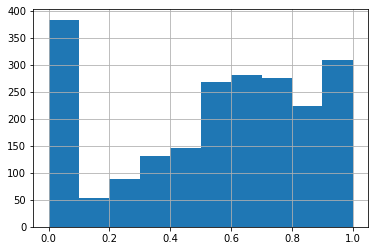

In [116]:
df_otif_groupby['percentage_OTIF'].hist()

## Join to safety stocks results df

In [117]:
# Join OTIF data to results df
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF = pd.merge(safety_stocks_df_with_SAP_ss_trimmed, 
         df_otif_groupby[['Plant-Material', 'percentage_OTIF']], 
         left_index = True,
         right_on='Plant-Material',
         how = 'left').set_index('Plant-Material')


In [118]:
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,lead_time_demand,reorder_point,...,Proposed_Value_SS,Proposed_Value_LTD,Proposed_Value_ROP,Difference_Proposed_SS_to_SAP_SS,Difference_Proposed_LTD_to_SAP_SS,Difference_Proposed_ROP_to_SAP_SS,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints,percentage_OTIF
Plant-Material,,,,,,,,,,,,,,,,,,,,,
EN0113591107,A,98.00,2.05,7.95,4.61,3.13,1.38,18.55,24.91,43.46,...,40523.28,54409.42,94932.69,40523.28,54409.42,94932.69,0.00,15,48,0.00
EN0112492744,A,98.00,2.05,36.64,28.87,3.97,1.37,119.31,145.34,264.65,...,56943.22,69367.24,126310.46,33079.22,45503.24,102446.46,2.00,17,59,0.58
EN0112621290,A,98.00,2.05,7.71,6.48,4.67,0.50,28.88,35.96,64.84,...,45453.66,56590.05,102043.71,21848.76,32985.15,78438.81,0.00,29,25,NaN
EN0112093576,A,98.00,2.05,5716.60,11352.08,4.90,1.83,51609.25,28011.34,79620.59,...,18243.87,9902.01,28145.88,17360.12,9018.26,27262.13,11.00,13,50,0.79
EN0113287304,A,98.00,2.05,4675.65,4793.09,1.63,0.25,12580.62,7636.90,20217.52,...,16713.36,10145.62,26858.98,16713.36,10145.62,26858.98,0.00,45,45,0.78
EN0112494262,A,98.00,2.05,537.78,469.72,1.47,0.35,1168.40,788.74,1957.14,...,15072.40,10174.76,25247.15,15072.40,10174.76,25247.15,0.00,193,48,0.38
EN0112094423,A,98.00,2.05,28771.48,13395.85,3.50,1.08,51471.05,100700.17,152171.23,...,43889.37,85867.04,129756.41,14044.87,56022.54,99911.91,14.00,189,443,0.10
EN0113591111,A,98.00,2.05,7.79,4.34,3.80,0.66,17.78,29.60,47.38,...,13257.15,22068.87,35326.02,13257.15,22068.87,35326.02,0.00,10,51,0.00
EN0112115684,A,98.00,2.05,5.59,4.46,3.73,1.01,18.36,20.87,39.23,...,18401.98,20923.03,39325.01,12387.52,14908.57,33310.55,0.00,15,49,0.00


In [119]:
# Calculate difference between desired OTIF level (service level) and actual
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['DSL_minus_OTIF'] = (safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['DSL']/100.0) - safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['percentage_OTIF']

## Attach stock value and margin data - calculate 'margin at risk' 

In [120]:
df_otif.head()

,(Self) Object Type EA,(Self) ID,Delivery Header Delivery Type,(Self) Execution Status,(Self) Overall status,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Realized Finish Date,(Self) Issuing Plant,Material Material,...,SD Header Requested deliv.date,(Self) Act. Gds Mvmnt Date,SD Item Sales Value,Material Plant EA_PROPERTY_PlanProfiel,SD Item Price per Unit,SD Item Margin,Deliv_status_bool,On_time_bool,OTIF_bool,Plant-Material
0,Delivery Item,84144816/10,LR (Returns Delivery),Open,Open,07-10-2016,Late,NaN,EN01,12616081,...,2016-08-22,NaT,0.00,VPFZ,0.00,206.13,True,False,False,EN0112616081
1,Delivery Item,84144847/10,LR (Returns Delivery),Open,Open,28-10-2016,Late,NaN,EN01,12508183,...,2016-10-28,NaT,-68.06,VPFZ,0.14,-20.61,True,False,False,EN0112508183
2,Delivery Item,84160961/10,LR (Returns Delivery),Closed,Completed,02-01-2019,Delivered late,04-01-2019,EN01,13403025,...,NaT,2019-01-04,NaN,VPFZ,NaN,NaN,False,False,False,EN0113403025
3,Delivery Item,84160981/10,LR (Returns Delivery),Closed,Completed,17-12-2018,Delivered late,07-01-2019,EN01,11387829,...,NaT,2019-01-07,NaN,VPFZ,NaN,NaN,False,False,False,EN0111387829
4,Delivery Item,84160982/10,LR (Returns Delivery),Closed,Completed,31-01-2019,Delivered early,07-01-2019,EN01,12746725,...,NaT,2019-01-07,NaN,VPFZ,NaN,NaN,False,False,False,EN0112746725


In [121]:
df_otif['SD Item Sales Value'].describe()

count    82103.00
mean      1436.66
std       3696.86
min     -11012.22
25%        115.72
50%        384.00
75%       1199.84
max     308475.00
Name: SD Item Sales Value, dtype: float64

In [122]:
df_otif['OTIF_bool'] = df_otif['OTIF_bool'].astype(bool)

# 
total_stock_value_non_otif_deliveries = df_otif.loc[df_otif['OTIF_bool'] == False, 'SD Item Sales Value'].sum()
print (total_stock_value_non_otif_deliveries)

42381031.4475955


Woah, that's huge. So this is the stock value which is being delivered non-OTIF. 

But, I just realised that this isn't what's most important. What is most important is the profit/margin that's at stake. So I added that to the EA extract, and let's take a look at it's value:

In [123]:
total_margin_non_otif_deliveries = df_otif.loc[df_otif['OTIF_bool'] == False, 'SD Item Margin'].sum()
print (total_margin_non_otif_deliveries)

13289412.816769699


Wow, is that right? 13 million margin on just these SKUs? That seems too high. Well, I suppose if it's all delivery lines we've ever had, for all our customer forecast SKUs...

Let's do some back-of-the-envelope calculations. Let's say that 5% of this value is at risk, when we deliver it non-OTIF. That's:

In [124]:
print ((total_margin_non_otif_deliveries/100.0) * 5.0)

664470.640838485


That's about 631K Euros per year. Now, let's say that, increasing the safety stock levels to the proposed levels would reduce the likelihood of an order being non-OTIF by 50%. 

That would mean, that increasing the safety stocks to the proposed levels could save ERIKS around 315K Euros per year, in terms of orders that are 'at risk', due to them being non-OTIF. Customers don't like that we can't deliver on time, and so they might go elsewhere. 

Data seems to start around 2018 (some earlier dates which we'll ignore for now). 

That's around 3.5 years of data. So let's divide 315k by 3.5:


In [125]:
print (630682.61138491 / (2*3.5))

90097.51591213


That's around 90K, if you set the value at risk % at 1%, and the 'influence of improved safety stocks' at 50%. 

# Second stage diagnostics 

Let's filter out negative demand amounts, to bring down the standard deviation values.

Note: I think this may have been for the visualisation, but it is a valid question for the actual safety stock levels. Should we include returns (now negative demand) in the safety stock calculations? 

In [126]:
print (len(df_demand_movement_type_filtered_lt_SKUs_filtered))
print (df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'].nunique())

df_demand_movement_type_filtered_lt_SKUs_filtered = df_demand_movement_type_filtered_lt_SKUs_filtered[
    df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/- flipped'] >= 0]


print (len(df_demand_movement_type_filtered_lt_SKUs_filtered))
print (df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'].nunique())

127425
2161
124482
2161


## Diagnostic plots

In [127]:
# Select a test ID to visualise
SKU_for_analysis = 'EN0113590906'

Quantities to visualise:
1. Historic demand amounts 
2. Historic lead-times 
3. Mean demand, on historic demand viz
4. Mean lead-time, on historic lead-time viz 
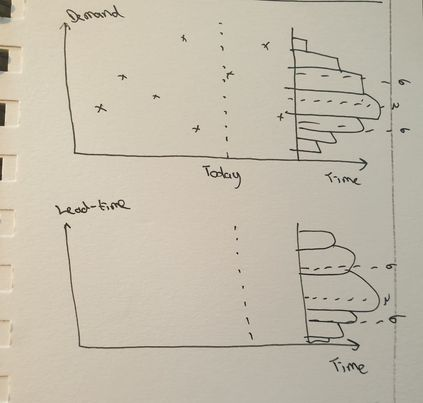

## Demand plot

In [128]:
df_demand_SKU_for_analysis = df_demand_movement_type_filtered_lt_SKUs_filtered[
    df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'] == SKU_for_analysis]

df_forecast_lines_SKU_for_analysis = df_forecast_lines[
    df_forecast_lines['Plant-Material'] == SKU_for_analysis]

df_demand_SKU_for_analysis.describe()

,(Self) Quantity +/- flipped
count,76.00
mean,13.22
std,12.63
min,0.09
25%,5.00
50%,10.00
75%,20.00
max,60.00


0.01    0.28
0.16    3.00
0.25    5.00
0.50   10.00
0.75   20.00
0.84   20.00
0.99   60.00
Name: (Self) Quantity +/- flipped, dtype: float64


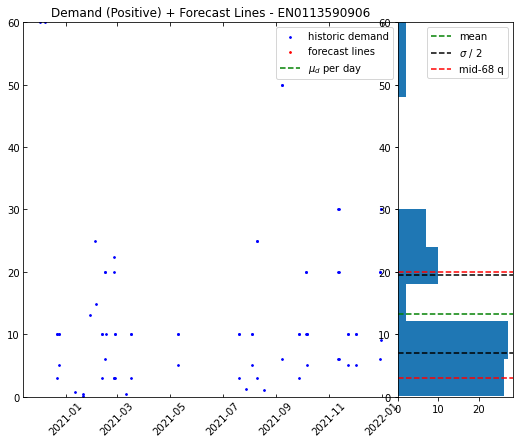

In [129]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.00


rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)

x_demand = df_demand_SKU_for_analysis['MDoc Header Posting Date']
y_demand = df_demand_SKU_for_analysis['(Self) Quantity +/- flipped']

x_forecast_lines = df_forecast_lines_SKU_for_analysis['MDoc Header Posting Date']
y_forecast_lines = df_forecast_lines_SKU_for_analysis['(Self) Quantity +/- flipped']

y_demand_plus_forecast_lines = pd.concat([y_demand, y_forecast_lines])
mean_demand_plus_forecast_lines = np.mean(y_demand_plus_forecast_lines)
std_demand_plus_forecast_lines = np.std(y_demand_plus_forecast_lines)
                                          
                                                                 
# the scatter plot:
ax_scatter.scatter(x_demand, y_demand, color = 'b', s = 3.0, label = 'historic demand')
ax_scatter.scatter(x_forecast_lines, y_forecast_lines, color = 'r', s = 3.0, label = 'forecast lines')
ax_scatter.set_ylim([0, max(y_demand_plus_forecast_lines)])

# now determine nice limits by hand:

print (y_demand_plus_forecast_lines.quantile([.01, .16, .25, .5, .75, .84, .99]))
quantile_16 = y_demand_plus_forecast_lines.quantile([0.16])
quantile_84 = y_demand_plus_forecast_lines.quantile([0.84])

ax_histy.hist(y_demand_plus_forecast_lines, orientation='horizontal')
ax_histy.axhline(mean_demand_plus_forecast_lines, linestyle = '--', color = 'g', label = 'mean')
ax_histy.axhline(mean_demand_plus_forecast_lines + std_demand_plus_forecast_lines/2.0, linestyle = '--', color = 'k', label = '$\sigma$ / 2')
ax_histy.axhline(mean_demand_plus_forecast_lines - std_demand_plus_forecast_lines/2.0, linestyle = '--', color = 'k')
ax_histy.axhline(quantile_16.values, linestyle = '--', color = 'r', label = 'mid-68 q')
ax_histy.axhline(quantile_84.values, linestyle = '--', color = 'r')
ax_histy.set_ylim([0, max(y_demand_plus_forecast_lines)])

ax_histy.legend()

ax_scatter.tick_params(axis='x', rotation=45)
ax_scatter.set_title('Demand (Positive) + Forecast Lines' + ' - ' + SKU_for_analysis)

mean_demand_per_day = safety_stocks_df_with_SAP_ss_trimmed.loc[SKU_for_analysis, 'mean_demand']
ax_scatter.axhline(mean_demand_per_day, label = '$\mu_{d}$ per day', linestyle = '--', color = 'g')
ax_scatter.legend()

plt.show()

## Lead-time plot

4
0.01    34.00
0.16    34.00
0.25    34.00
0.50   141.50
0.75   249.00
0.84   249.00
0.99   249.00
Name: Lead-time in days, dtype: float64


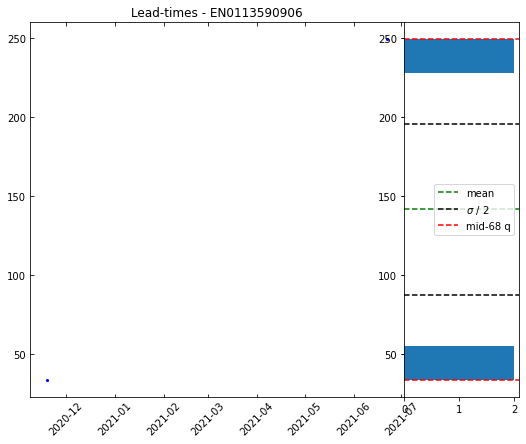

In [130]:
df_lt_SKU_for_analysis = df_lt_demand_SKUs_filtered[
    df_lt_demand_SKUs_filtered['Plant-Material'] == SKU_for_analysis]

df_lt_SKU_for_analysis = df_lt_SKU_for_analysis.dropna()

print (len(df_lt_SKU_for_analysis))
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.00

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)

x_lt = df_lt_SKU_for_analysis['(Self) Date of Goods Receipt']
y_lt = df_lt_SKU_for_analysis['Lead-time in days']

mean_lt = np.mean(y_lt)
std_lt = np.std(y_lt)
                                          
                                                                 
# the scatter plot:
ax_scatter.scatter(x_lt, y_lt, color = 'b', s = 3.0)

# now determine nice limits by hand:

print (y_lt.quantile([.01, .16, .25, .5, .75, .84, .99]))
quantile_16 = y_lt.quantile([0.16])
quantile_84 = y_lt.quantile([0.84])

ax_histy.hist(y_lt, orientation='horizontal')
ax_histy.axhline(mean_lt, linestyle = '--', color = 'g', label = 'mean')
ax_histy.axhline(mean_lt + std_lt/2.0, linestyle = '--', color = 'k', label = '$\sigma$ / 2')
ax_histy.axhline(mean_lt - std_lt/2.0, linestyle = '--', color = 'k')
ax_histy.axhline(quantile_16.values, linestyle = '--', color = 'r', label = 'mid-68 q')
ax_histy.axhline(quantile_84.values, linestyle = '--', color = 'r')
ax_histy.legend()

ax_scatter.tick_params(axis='x', rotation=45)
ax_scatter.set_title('Lead-times' + ' - ' + SKU_for_analysis)
plt.show()

# Package Requirements

In [131]:
import session_info
session_info.show()

Result from Shaheen's machine

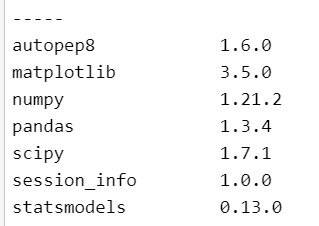

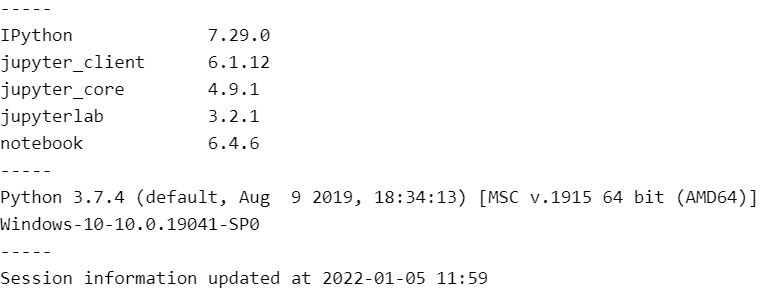